In [18]:
import cv2
import numpy as np
import os

In [19]:
dsPath = "./hand_washing_ds/HandWashDataset/"

In [20]:
classFolderMap = {
    0 : 'Step_1',
    1 : 'Step_2_Left',
    2 : 'Step_2_Right',
    3 : 'Step_3',
    4 : 'Step_4_Left',
    5 : 'Step_4_Right',
    6 : 'Step_5_Left',
    7 :'Step_5_Right',
    8 : 'Step_6_Left',
    9 :'Step_6_Right',
    10 : 'Step_7_Left',
    11 : 'Step_7_Right',
}

In [21]:
img_rows,img_cols,img_depth=32,32,15
x_set = []
y_labels = []

for key, val in classFolderMap.items():
    videosInFolder = os.listdir(dsPath+val)
    for vid in videosInFolder:
        cap = cv2.VideoCapture(dsPath + val + "/" + vid)
        # fps = cap.get(5)
        # print(fps)
        enoughFrames = True
        
        for bundle in range(20):

            frames = []
            for k in range(15):
                ret, frame = cap.read()
                if not ret:
                    print("Not enough frames in ", vid)
                    enoughFrames = False
                    break
                frame = cv2.resize(frame,
                     (img_rows, img_cols), interpolation= cv2.INTER_AREA)
                grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frames.append(grayFrame)
            
            if not enoughFrames:
                break
            inputs = np.array(frames)
            ipt = np.rollaxis(np.rollaxis(inputs,2,0),2,0)
            x_set.append(ipt)
            y_labels.append(key)
        cap.release()
    print(len(y_labels))
    print(val + ", done")

500
Step_1, done
Not enough frames in  HandWash_012_A_03_G_03.mp4
Not enough frames in  HandWash_001_A_03_G_01.mp4
Not enough frames in  HandWash_024_A_02_G_05.mp4
Not enough frames in  HandWash_025_A_02_G_05.mp4
986
Step_2_Left, done
Not enough frames in  HandWash_020_A_03_G_05.mp4
Not enough frames in  HandWash_023_A_03_G_05.mp4
Not enough frames in  HandWash_025_A_03_G_05.mp4
Not enough frames in  HandWash_024_A_03_G_05.mp4
Not enough frames in  HandWash_014_A_02_G_03.mp4
1475
Step_2_Right, done
Not enough frames in  HandWash_024_A_04_G_05.mp4
Not enough frames in  HandWash_016_A_04_G_04.mp4
Not enough frames in  HandWash_025_A_04_G_05.mp4
1967
Step_3, done
Not enough frames in  HandWash_019_A_05_G_05.mp4
Not enough frames in  HandWash_025_A_05_G_05.mp4
Not enough frames in  HandWash_013_A_05_G_03.mp4
2460
Step_4_Left, done
Not enough frames in  HandWash_024_A_06_G_05.mp4
Not enough frames in  HandWash_019_A_06_G_05.mp4
Not enough frames in  HandWash_025_A_06_G_05.mp4
2949
Step_4_Ri

In [25]:
type(y_labels)

list

In [26]:
x_data = np.array(x_set)
y_data = np.array(y_labels)

In [28]:
numOfSamples = len(x_data)

In [29]:
x_data.shape

(5719, 32, 32, 15)

In [33]:
train_set = np.zeros((numOfSamples, img_rows, img_cols, img_depth, 1))

In [34]:
for h in range(numOfSamples):
    train_set[h,:,:,:,0]=x_data[h,:,:,:]

In [35]:
patch_size = 15 

In [38]:
batch_size = 4
nb_classes = 12
nb_epoch = 50

In [39]:
from keras.utils import np_utils

In [40]:
y_train = np_utils.to_categorical(y_data, nb_classes)

In [41]:
nb_filters = [  32,   # 1st conv layer
                32    # 2nd
             ]

In [42]:
train_set = train_set.astype('float32')
train_set -= np.mean(train_set)
train_set /= np.max(train_set)

In [44]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.callbacks import TensorBoard

In [46]:
RMSprob = RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

# Models building Basic

In [47]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import datetime
import pdb

In [48]:
model = Sequential()
print('input shape', img_rows, 'rows', img_cols, 'cols', patch_size, 'patchsize')
model.add(Conv3D(nb_filters[0],(5,5,5),input_shape=(img_rows, img_cols,patch_size,1),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(BatchNormalization(momentum=0.99))

model.add(Conv3D(nb_filters[1],(3,3,3),activation='relu'))

model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])


input shape 32 rows 32 cols 15 patchsize


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 28, 11, 32)    4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 9, 3, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 3, 32)       128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 7, 1, 32)       27680     
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [50]:
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, y_train,
                                                                 test_size=0.2, random_state=4)

In [51]:
hist = model.fit(X_train_new,
			    y_train_new,
			    validation_data=(X_val_new,y_val_new),
			    batch_size=batch_size,
			    epochs = nb_epoch,
			    shuffle=True,
			    callbacks=[TensorBoard(log_dir='./log')] )#tensorboard --logdir=./log

Epoch 1/50
1144/1144 [==============================] - 258s 206ms/step - loss: 2.8155 - mse: 0.0763 - accuracy: 0.2996 - val_loss: 0.8175 - val_mse: 0.0298 - val_accuracy: 0.7517
Epoch 2/50
1144/1144 [==============================] - 234s 204ms/step - loss: 0.7008 - mse: 0.0256 - accuracy: 0.7850 - val_loss: 0.3795 - val_mse: 0.0137 - val_accuracy: 0.8846
Epoch 3/50
1144/1144 [==============================] - 234s 205ms/step - loss: 0.4766 - mse: 0.0166 - accuracy: 0.8673 - val_loss: 0.3435 - val_mse: 0.0112 - val_accuracy: 0.9143
Epoch 4/50
1144/1144 [==============================] - 235s 205ms/step - loss: 0.3788 - mse: 0.0121 - accuracy: 0.9062 - val_loss: 0.3332 - val_mse: 0.0089 - val_accuracy: 0.9318
Epoch 5/50
1144/1144 [==============================] - 232s 203ms/step - loss: 0.3030 - mse: 0.0109 - accuracy: 0.9134 - val_loss: 0.3719 - val_mse: 0.0112 - val_accuracy: 0.9152
Epoch 6/50
1144/1144 [==============================] - 232s 203ms/step - loss: 0.3036 - mse: 0.0102

1144/1144 [==============================] - 232s 202ms/step - loss: 0.0634 - mse: 9.9247e-04 - accuracy: 0.9939 - val_loss: 0.3705 - val_mse: 0.0023 - val_accuracy: 0.9860
Epoch 47/50
1144/1144 [==============================] - 232s 202ms/step - loss: 0.0541 - mse: 9.2307e-04 - accuracy: 0.9938 - val_loss: 0.3503 - val_mse: 0.0026 - val_accuracy: 0.9843
Epoch 48/50
1144/1144 [==============================] - 232s 203ms/step - loss: 0.0407 - mse: 9.6789e-04 - accuracy: 0.9937 - val_loss: 0.5144 - val_mse: 0.0030 - val_accuracy: 0.9816
Epoch 49/50
1144/1144 [==============================] - 232s 203ms/step - loss: 0.0720 - mse: 9.6650e-04 - accuracy: 0.9932 - val_loss: 0.5467 - val_mse: 0.0033 - val_accuracy: 0.9790
Epoch 50/50
1144/1144 [==============================] - 232s 203ms/step - loss: 0.0647 - mse: 9.7449e-04 - accuracy: 0.9940 - val_loss: 0.4546 - val_mse: 0.0035 - val_accuracy: 0.9773


In [52]:
now = str(datetime.datetime.now()).split('.')[0]
model.save('./models/'+now+"-model.h5")

In [54]:
score = model.evaluate(X_val_new,y_val_new,batch_size=batch_size)
# Print the results
print('**********************************************')
print('Test score:', score)
print('History', hist.history)

286/286 [==============================] - 7s 23ms/step - loss: 0.4546 - mse: 0.0035 - accuracy: 0.9773
**********************************************
Test score: [0.4546187222003937, 0.003497058292850852, 0.9772727489471436]
History {'loss': [1.7779598236083984, 0.6425966024398804, 0.4514773190021515, 0.3581755757331848, 0.3030051589012146, 0.26551660895347595, 0.250520795583725, 0.2304605096578598, 0.2121354043483734, 0.18522176146507263, 0.1861191689968109, 0.1786932647228241, 0.17971284687519073, 0.14842523634433746, 0.16007228195667267, 0.1277974247932434, 0.11197154968976974, 0.11234736442565918, 0.09926901757717133, 0.09972324222326279, 0.08735731244087219, 0.09762334078550339, 0.11538712680339813, 0.07950188964605331, 0.0954858660697937, 0.08612161129713058, 0.09914933890104294, 0.10078944265842438, 0.07781572639942169, 0.0757206380367279, 0.09518367052078247, 0.05423225834965706, 0.08445937186479568, 0.08089060336351395, 0.04388180002570152, 0.08566810190677643, 0.057674888521

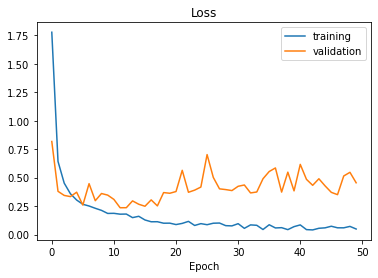

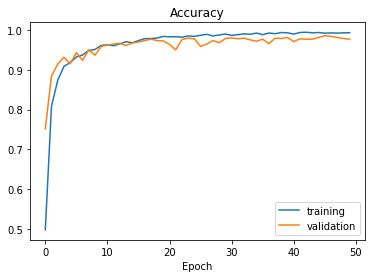

In [56]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel("Epoch")

plt.figure(2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel("Epoch")

plt.show()


In [57]:
import sys,pdb,natsort

In [58]:
files = os.listdir('./test/')

In [59]:
nb_files = len(files)


In [61]:
print('number of files:%s'%(nb_files))
files = natsort.natsorted(files)

number of files:2


In [62]:
lets_test_for = []

In [63]:
for f in files: 
    frames = []
    path = './test/'+f
    cap = cv2.VideoCapture(path)
    fps = cap.get(5)
    img_rows,img_cols,img_depth=32,32,15
    for k in range(15):
        ret, frame = cap.read()
        frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    inputs=np.array(frames)
    ipt=np.rollaxis(np.rollaxis(inputs,2,0),2,0)
    lets_test_for.append(ipt)

lets_test_for = np.array(lets_test_for)

In [64]:
test_set = np.zeros((nb_files, img_rows, img_cols, img_depth, 1))

In [65]:
for i in range(nb_files):
	test_set[i,:,:,:,0]=lets_test_for[i,:,:,:]

In [66]:
test_set = test_set.astype('float32')
test_set -= np.mean(test_set)
test_set /= np.max(test_set)

In [67]:
results = []#predict results

In [68]:
y = model.predict(test_set)

In [70]:
for j in range(nb_files):
    index = np.argmax(y[j])
    action = classFolderMap[index]
    results.append(action)
print("File names | Predict labels")


for pair in zip(files,results):
    print(pair)

File names | Predict labels
('HandWash_004_A_01_G01.mp4', 'Step_1')
('HandWash_007_A_08_G_01.mp4', 'Step_5_Right')
